## To-do Functions:
- Read sto file.     x
- Read a directory with sto files     x
- Extract sequence and head.    x
- recognize different types of information from the file.     x
- Make graph.    x
- Create new text file and write seqs and the different relations into it.  x
- create graphs with different type of information (user entry).    x
- create mereged graphs file based on the partition class file.

In [1]:
%matplotlib inline
import os, sys
import subprocess as sp
from itertools import cycle
import networkx as nx
import re
import ntpath
from eden.util import display

In [2]:
"""read a Sto file separate the head and the sequence"""
def _readStoFile(file_path =None):
    head_mark0 = '#'
    head_mark1 = '='
    head_mark2 = 'G'
    head_mark3 = 'C'
    head_list = []
    sequence_list = []  
    
    #""" for file in os.listdir(path): #open file """
    read_file = open(file_path ,'r') 
    
    for line in read_file:
        
        lines = list(line)
            # the read line is the head of the sequence write it in head list
        if lines[0] == head_mark0 and lines[1] == head_mark1 and lines[2] == head_mark2 and lines[3] == head_mark3:
            line = line.strip('#=GC ')            
            line = line.strip('\n')
            line = line.split(' ')
            line = filter(None, line)

            head = line[0]
            head_list.append(head)
            sequence = line[1].split()
            sequence_list.append(sequence)
            zip_head_seqs = zip(head_list, sequence_list)
      
    return zip_head_seqs

In [3]:
"""Recognize the different types of information (cons, sscons, consSS, entropy, cov)"""
def _identifyInformationType(file_name, head_seq_list):

    secondery_structure_s = []
    conservation_s = []
    conservation_stringth_s = []
    entropy_0_s = []
    entropy_1_s = []
    entropy_2_s = []
    entropy_3_s = []
    coveration_s = []

    for i, elemant in enumerate(head_seq_list):
        info_item = head_seq_list[i]
        
        if info_item[0] == 'SS_cons':
            secondery_structure_s.append(str(info_item[1]))
            
        if info_item[0] == 'cons':
            conservation_s.append(str(info_item[1]))
            
        if info_item[0] == 'conss':
            conservation_stringth_s.append(info_item[1])
            
        if info_item[0] == 'col_entropy_0':
            entropy_0_s.append(info_item[1])
            
        if info_item[0] == 'col_entropy_1':
            entropy_1_s.append(info_item[1])

        if info_item[0] == 'col_entropy_2':
            entropy_2_s.append(info_item[1])
            
        if info_item[0] == 'col_entropy_3':
            entropy_3_s.append(info_item[1])   
            
        if info_item[0] == 'cov_SS_cons':
            coveration_s.append(info_item[1])
    #print '#########'
    file_dictionary = {"ID_file name": file_name, "conservation": conservation_s, "secondery_structure": secondery_structure_s,
                       "conservation_stringth": conservation_stringth_s, "entropy_3": entropy_3_s, "covaration": coveration_s}
    return file_dictionary

In [4]:
"""Writ seq file as t \n v or V info \n e v1v2\n"""
def _writeGraphFile(file_path, info_type, struc):
    
    file_extention = '.g'
    next_relation = 'next'
    #basepair_relation = 'bp'
    
    dir_name = ntpath.dirname(file_path)
    new_file_name = ntpath.splitext( ntpath.basename(file_path))[0]
    new_file_name = dir_name + "/" + new_file_name + file_extention
 
    new_file = open(ntpath.join(file_path, new_file_name), 'w+')
    new_file.write('t\n')

    info_types = list(info_type)
    for i, info in enumerate(info_types):
        new_file.write('V' + ' ' + str(i) + ' ' + str(info) + '\n')
        if i != 0:
            j = i-1
            new_file.write('e' + ' ' + str(j) + ' ' + str(i) + ' ' + next_relation + '\n')
    basepair_relation = _identifyBasepair(new_file, struc)
    new_file.close()
    

In [5]:
'''Recognize basepairs'''
def _identifyBasepair(new_file, struc):
    
    open_pran = "<"
    close_pran = ">"
    basepair_relation = 'bp'
    stack_o = []
    stack_j_o = []
    stack_c = []

    #seq_struc_zip = zip(seq, struc)
    for i, k in enumerate(struc):
        """find basepair and connect them"""
        if struc[i] == open_pran:
            j = i
            stack_o.append(struc[j])
            stack_j_o.append(j)
            open_len = len(stack_o)

        if struc[i] == close_pran:
            stack_c.append(struc[i])
            close_len = len(stack_c)
            j = stack_j_o.pop()
            new_file.write('e' + ' ' + str(j) + ' ' + str(i) + ' ' + basepair_relation + '\n')

    #return G 

In [6]:
'''Recognize basepairs and include them to the generated graph'''
def _makeGraph(head, graph_key, struc):
    
    print ("Graph title", head)
    open_pran = "<" or "(" or "[" or "{"
    close_pran = ">" or ")" or "]" or "}"
    stack_o = []
    stack_pos_o =[]
    stack_c = []
    G = nx.Graph()

    seq_struc_zip = zip(graph_key, struc)

    for i, k in enumerate(struc):
        G.add_node(i, label = graph_key[i])
        # connect with the next node 
        if i > 0:
            G.add_edge(i-1, i, label= 'x')
           
        """find basepair and connect them"""
        if struc[i] == open_pran:
            j = i
            stack_o.append(struc[j])
            stack_pos_o.append(j)
            open_len = len(stack_o)

        if struc[i] == close_pran:
            stack_c.append(struc[i])
            stack_o.pop()
            j = stack_pos_o.pop()
            G.add_edge(i, j, label = 'b')

    return G 

## Experiments:

In [7]:
def _readFileAndGraphGenerating(file_path=None):
    file_name = ntpath.splitext( ntpath.basename(file_path))[0]
    head = file_name
    zip_head_seqs = _readStoFile(file_path)
    info_type = _identifyInformationType(head, zip_head_seqs)

    sequence = info_type['conservation']
    structure = info_type['secondery_structure']
    conservation_stringth = info_type['conservation_stringth']
    covaration = info_type['covaration']
    entropy_3 = info_type['entropy_3']
    
    sequence = sequence[0].strip('[\']')
    print ('seq', sequence)
    structure = structure[0].strip('[\']')
    print ('stru', structure)
    conservation_stringth = str(conservation_stringth[0]).strip('[\']')
    covaration = str(covaration).strip('[\']')
    entropy_3 = str(entropy_3[0]).strip('[\']')

    #write_file = _writeGraphFile(file_path, sequence, structure)
    drow_graph = _userGraphEntry(head, sequence, structure, covaration, conservation_stringth, entropy_3)

In [8]:
'''make the graph node as user specification using the dictionary key'''
def _userGraphEntry(head, sequence, structure, covaration, conservation_stringth, entropy_3):
  
    '''Get the graph type as input''' 
    graph_key = raw_input('enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): ')
    
    #single info in a node
    if graph_key == 'sequence':
        write_file = _writeGraphFile(file_path, sequence, structure)
        G = _makeGraph(head, sequence, structure)
    if graph_key == 'conservation_stringth':
        write_file = _writeGraphFile(file_path, conservation_stringth, structure)
        G = _makeGraph(head, conservation, structure)
    if graph_key == 'covaration':
        write_file = _writeGraphFile(file_path, covaration, structure)
        G = _makeGraph(head, covaration, structure)
    if graph_key == 'entropy_3':
        write_file = _writeGraphFile(file_path, entropy_3, structure)
        G = _makeGraph(head, entropy_3, structure)
        
    # 2 type of information in one node
    if graph_key == 'sequence, covaration':
        cons_cov = zip(sequence,covaration)
        write_file = _writeGraphFile(file_path, cons_cov, structure)
        G = _makeGraph(head, cons_cov, structure)
    if graph_key == 'sequence, conservation_stringth':
        cons_conss = zip(sequence,conservation_stringth)
        write_file = _writeGraphFile(file_path, cons_conss, structure)
        G = _makeGraph(head, cons_conss, structure)
    if graph_key == 'sequence, entropy_3':
        cons_ent = zip(sequence,covaration)
        write_file = _writeGraphFile(file_path, cons_ent, structure)
        G = _makeGraph(head, cons_ent, structure)
        
    # 3 type of information in one node
    if graph_key == 'sequence, covaration, conservation_stringth':
        cons_cov_conss = zip(sequence,covaration, conservation_stringth)
        write_file = _writeGraphFile(file_path, cons_cov_conss, structure)
        G = _makeGraph(head, cons_cov_conss, structure)
  
    display.draw_graph(G, size=25, node_size=250, font_size=12, node_border=True, prog='neato')

## Read one file

('seq', 'nnCC-nGn-CCGGGCCCCUCUGGCAGYnC--n--Ann--GnRCUGYGAUGUCGGA-YUGGnn')
('stru', '<<<<.<<-.<<<<---------<<<<<<<.._.._._..>>>>>>>---->>>>-.>>>>>>')
enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): sequence, covaration, conservation_stringth
('Graph title', '550-53949-1-0')


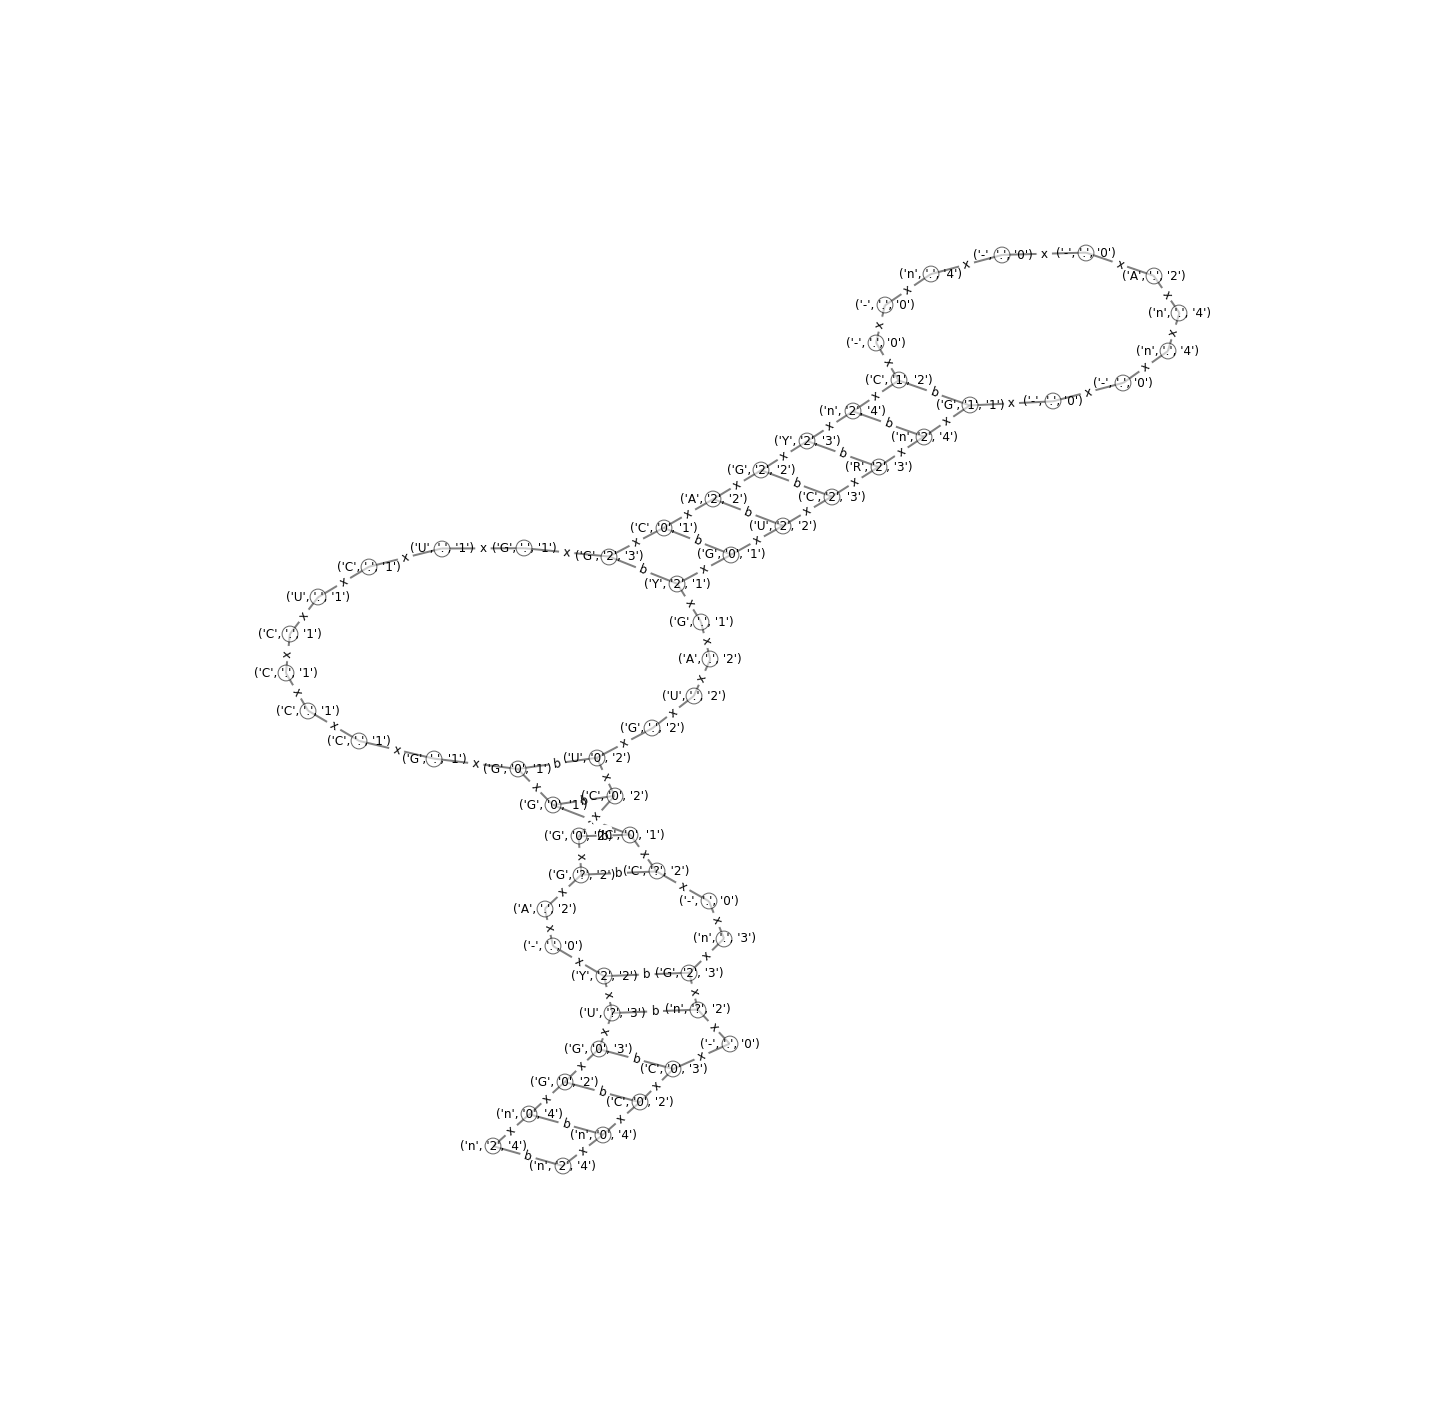

In [9]:
file_path = "/home/alsheikm/GitDir/EeDN_work/StoExamples/StoExmapleSmall/positives-sto/550-53949-1-0.sto"
File_to_Graph = _readFileAndGraphGenerating(file_path)


## Read a directory

In [10]:
"""read a fasta file separate the head and the sequence"""
def _readStoDir(file_path):
    head_mark0 = '#'
    head_mark1 = '='
    head_mark2 = 'G'
    head_mark3 = 'C'
    head_list = []
    sequence_list = []  
    
    #""" for file in os.listdir(path): #open file """
    read_file = open(file_path ,'r')    
    for line in read_file:
        lines = list(line)
            # the read line is the head of the sequence write it in head list
        if lines[0] == head_mark0 and lines[1] == head_mark1 and lines[2] == head_mark2 and lines[3] == head_mark3:
            #print ('read line',line)
            line = line.strip('#=GC ')            
            line = line.strip('\n')
            line = line.split(' ')
            line = filter(None, line)

            head = line[0]
            head_list.append(head)
            sequence = line[1].split()
            sequence_list.append(sequence)
            zip_head_seqs = zip(head_list, sequence_list)
      
    return zip_head_seqs

In [11]:
'''NOT DONE YET'''
'''Writ mergen file based on the file classs'''
def _writeMergeClassFile(partition_dir, file_dir):
    '''check the partition file for each file in the pos/neg-sto'''
    print partition_dir
    print file_dir
    '''use re.findall(''\\bfile_name\\b, partition_file)
     for file in file_dir:
         for line in parition_file:
         if file_name == line[0]:
            write graph file in merge_class_file(line[1])'''
    #for i, text_file in file_dir
    

In [16]:
#directory = "/home/alsheikm/GitDir/EeDN_work/StoExamples/StoExmapleSmall"
def _readFolderAndGraphsGenerating(directory = None):
    for file_path in os.listdir(directory):
        folder_path = os.path.join( directory, file_path)
        print folder_path
        for file_name in os.listdir(folder_path):
            '''test that the file has the sto extension'''
            file_extention = os.path.splitext(file_name)[-1].lower()
            if file_extention == '.sto': 
                head = ntpath.splitext(ntpath.basename(file_name))[0]
                file_complete_path = os.path.join( folder_path, file_name)
                zip_head_seqs = _readStoDir(file_complete_path)
                info_type = _identifyInformationType(head, zip_head_seqs)
                
                sequence = info_type['conservation']
                structure = info_type['secondery_structure']
                conservation_stringth = info_type['conservation_stringth']
                covaration = info_type['covaration']
                entropy_3 = info_type['entropy_3']

                sequence = sequence[0].strip('[\']')
                print ('seq', sequence)
                structure = structure[0].strip('[\']')
                print ('stru', structure)
                conservation_stringth = str(conservation_stringth[0]).strip('[\']')
                covaration = str(covaration).strip('[\']')
                entropy_3 = str(entropy_3[0]).strip('[\']')

                #write_file = _writeGraphFile(file_complete_path, sequence, structure)
                drow_graph = _userGraphEntry(head, sequence, structure, covaration, conservation_stringth, entropy_3)

In [17]:
'''make the graph node as user specification using the dictionary key'''
def _userGraphEntry(head, sequence, structure, covaration, conservation_stringth, entropy_3):
    
    '''Get the graph type as input'''
    graph_key = raw_input('enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): ')
    
    #single info in a node
    if graph_key == 'sequence':
        write_file = _writeGraphFile(file_path, sequence, structure)
        G = _makeGraph(head, sequence, structure)
    if graph_key == 'conservation_stringth':
        write_file = _writeGraphFile(file_path, conservation_stringth, structure)
        G = _makeGraph(head, conservation, structure)
    if graph_key == 'covaration':
        write_file = _writeGraphFile(file_path, covaration, structure)
        G = _makeGraph(head, covaration, structure)
    if graph_key == 'entropy_3':
        write_file = _writeGraphFile(file_path, entropy_3, structure)
        G = _makeGraph(head, entropy_3, structure)
        
    # 2 type of information in one node
    if graph_key == 'sequence, covaration':
        cons_cov = zip(sequence,covaration)
        write_file = _writeGraphFile(file_path, cons_cov, structure)
        G = _makeGraph(head, cons_cov, structure)
    if graph_key == 'sequence, conservation_stringth':
        cons_conss = zip(sequence,conservation_stringth)
        write_file = _writeGraphFile(file_path, cons_conss, structure)
        G = _makeGraph(head, cons_conss, structure)
    if graph_key == 'sequence, entropy_3':
        cons_ent = zip(sequence,covaration)
        write_file = _writeGraphFile(file_path, cons_ent, structure)
        G = _makeGraph(head, cons_ent, structure)
        
    # 3 type of information in one node
    if graph_key == 'sequence, covaration, conservation_stringth':
        cons_cov_conss = zip(sequence,covaration, conservation_stringth)
        write_file = _writeGraphFile(file_path, cons_cov_conss, structure)
        G = _makeGraph(head, cons_cov_conss, structure)
  
    display.draw_graph(G, size=25, node_size=250, font_size=12, node_border=True, prog='neato')

/home/alsheikm/GitDir/EeDN_work/StoExamples/StoExmapleSmall/positives-sto
('seq', 'Cnn---n--n-n-Rnnn--nn-nn-n---YYG----R--ACUGGUUCGnRAACnUCCCAGU')
('stru', '<<<...<.<<.<._____.__.>>>>...>>>....-..-<<<<____________>>>>:')
enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): sequence, covaration
('Graph title', '550-70730-0-0')


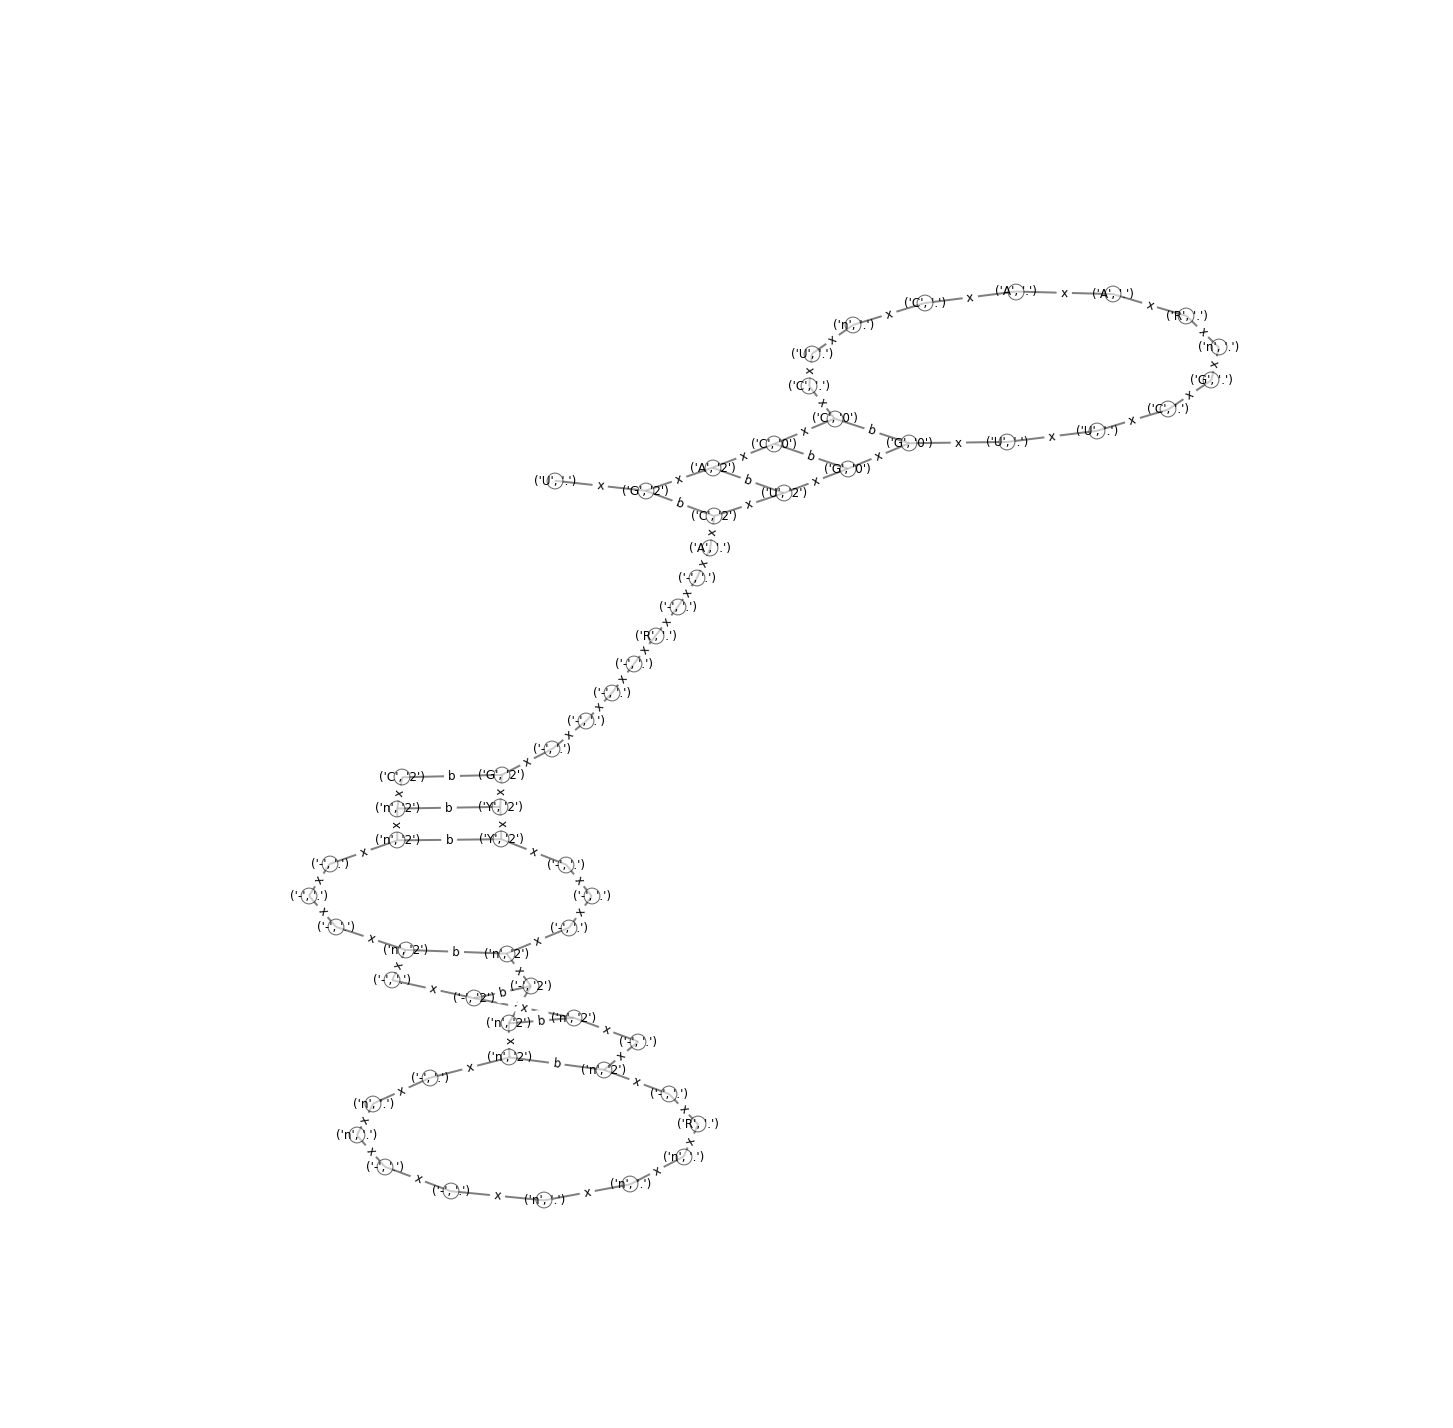

('seq', 'nnCC-nGn-CCGGGCCCCUCUGGCAGYnC--n--Ann--GnRCUGYGAUGUCGGA-YUGGnn')
('stru', '<<<<.<<-.<<<<---------<<<<<<<.._.._._..>>>>>>>---->>>>-.>>>>>>')
enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): sequence, covaration
('Graph title', '550-53949-1-0')


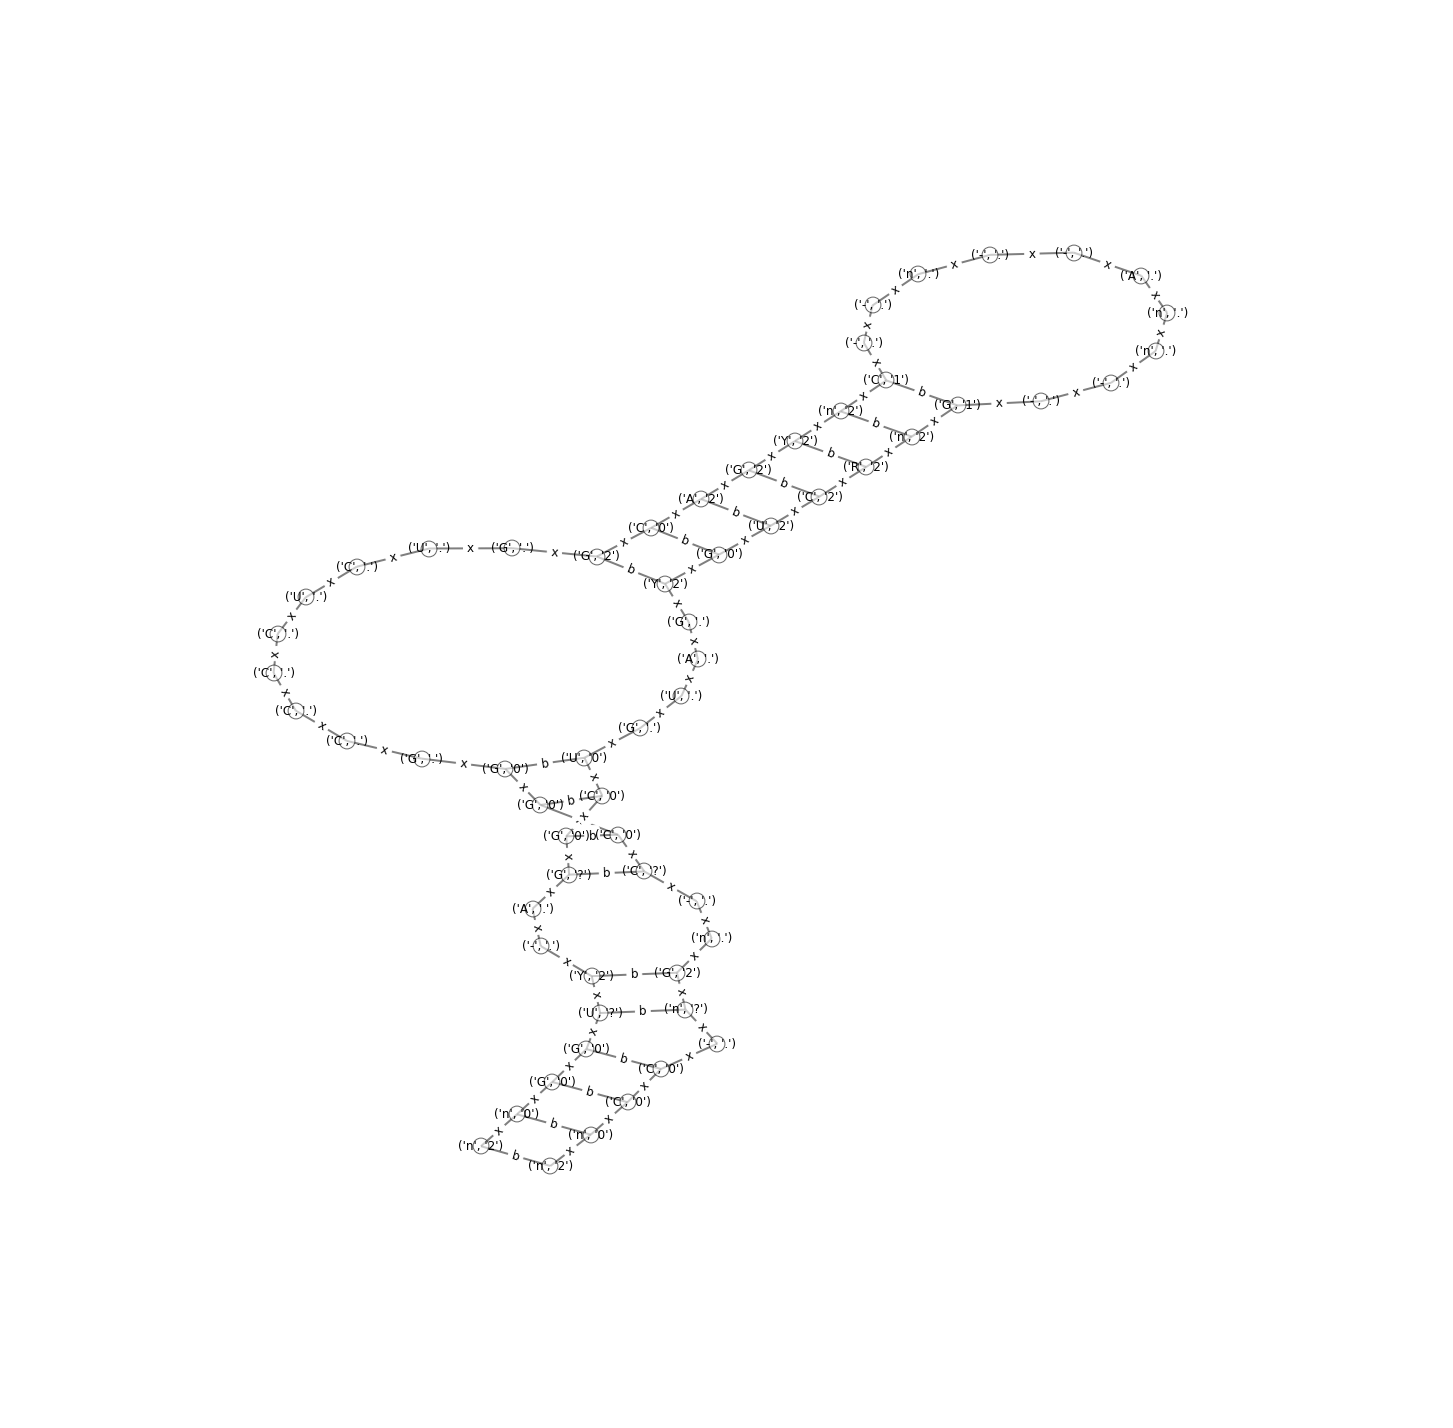

('seq', 'GGYAAAnYURGRGAAAUCYARnGACGCAAAGCUAnAGGGRCUAAGGUY-nAU---R-ACUAUGYYAGCCAGUUGCCRAAGRRnn------nnUAYUYUUUGUUnn---------------------YnnARnn--nnUUAAUYn-nnn-nnRU-nUAYA-YnA-nn-----Un-URn-AYn-------------nnRn--nUUUAn------YnnnRYn----------nn-ARCUnYYC--U---Unnn-----GRRnAGYU')
('stru', ':(((,,<<<<<<____>>>>>>,,,,,,,,,,,,,,,,<<<---<<<<.___...>.>>>-->>>,,,,,,,)))<<<<<<<<_......___>>>>>>>>,,,,.....................<<<<<------<<<<---.<<<.--<<.<<<<<____.__.....>>.>>>.>>--------------->>>..-->>>>-..--->>>>>,,,,,.......,,,,<<<-<<<___...____.__..>>>->>>:')
enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): sequence, covaration
('Graph title', '550-70852-0-0')


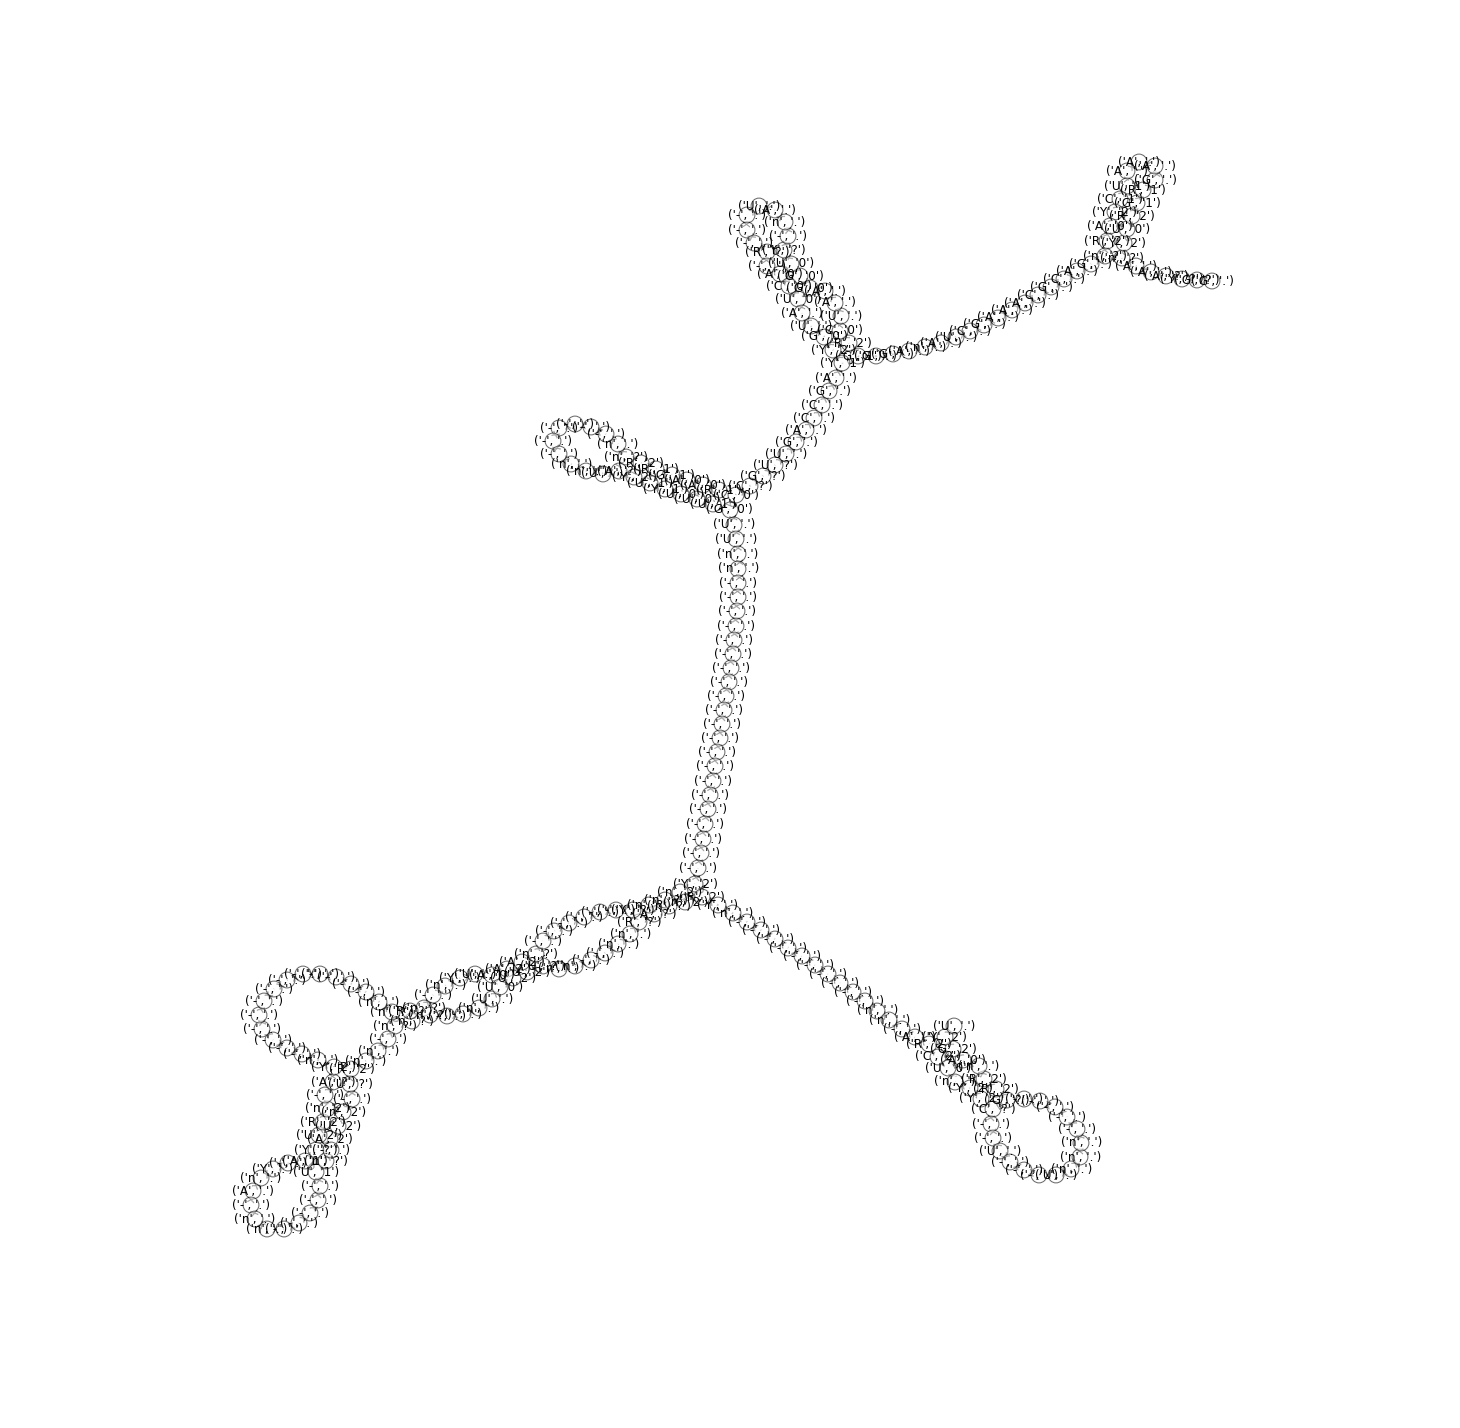

('seq', 'nnnU----nn-n-n-nnRnnnnn----n-nnnnnnn-nn-AR-nnn---n-------nn--nYnnnn-nn-Annnn--n-A----------------------------------nnnnCUCGUAUAUnn-YCR-GUAAUAUGGUCYGRn-A--GUUUCUACCUGCUAnCCnUAAA-nUAGCAGACUACGAGGnnnUGn-nn--nn------------------------nnnnU-nRUnU-nAnUn-nAUn-nnnn-n-------nnAn-n--n---R---RCAY--CYnn-nnUU-R--nn--nRRG-RUGUUnnUUnU')
('stru', ':<<<....<<.<.<.<<<---<<-...<.<<_____.__.__._>>...>.......>>..->>>>>.>>.>>>,,..,.,.............................,,,,,,,,,((((((,,,,,.<<<.<_________>>>>,.,..,,,,,,,,<<<<<<________._>>>>>>,,)))))),,,,,,,.,,..,,........................,,,,,.<<<__._____._>>>.,,,,.,.......,,<<.<..<...<...<<<<..<<<<-<<__._..>>.->>>>.>>>>>>>>>::')
enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): sequence, covaration
('Graph title', '550-69275-0-0')


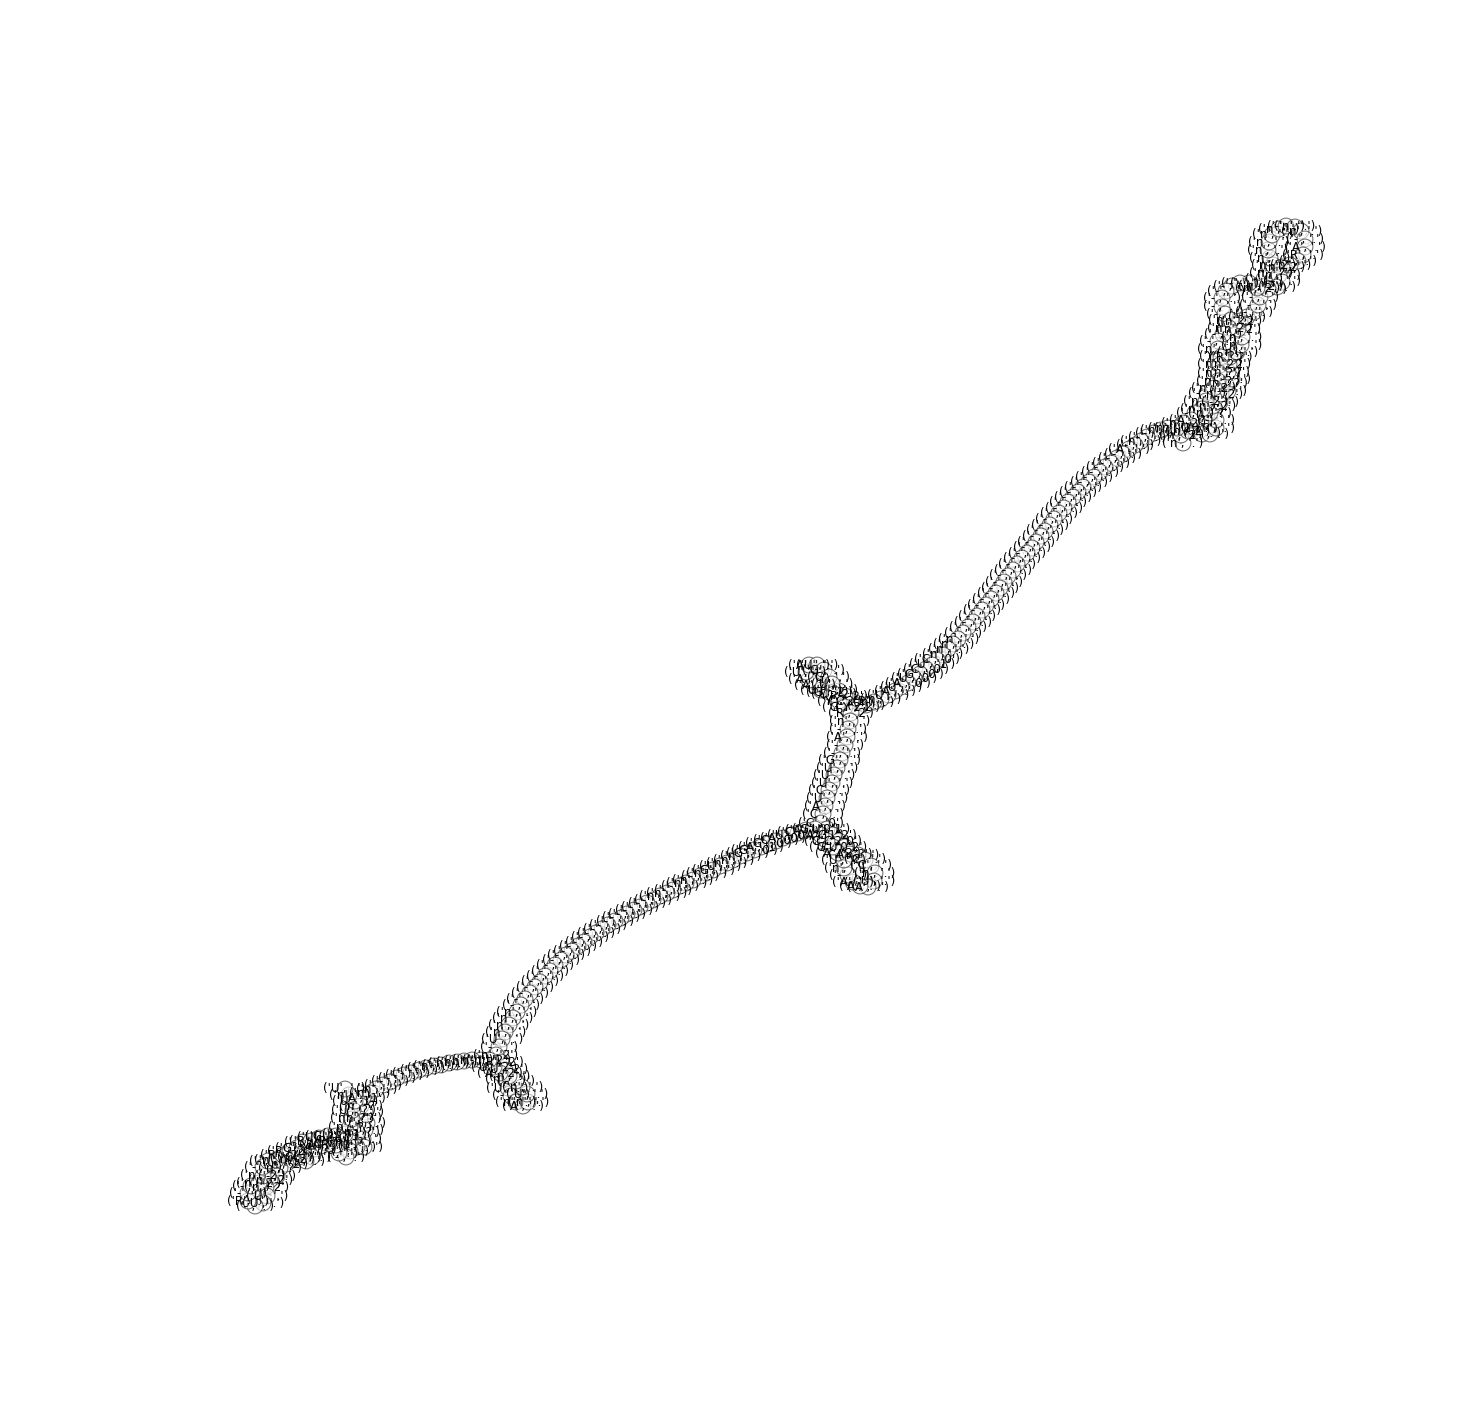

('seq', 'nnn----YCRUAUAnn-n-YYRR-n-R-AUAnGGn-YYRRRn-GUY-UCUAC-Cn-nRY-nACCGUAA-AUn-RYn--nGACUAYGnnnnnnnnn--------------------------------------------------------------------------------------------nnn-n-n---------nnn----n--n--n-n--n-nn-nnnnn---------------------------------------------------n-n------------nnn---nnn--------------------------------------------------------nn------n-n----n-n--nn---n-----n-nnnY')
('stru', '::(....(((((,,,<.<.<<<<.<._.______>.>>>>>>.,,,.,,,,,.<<.<<<.<<______._>>.>>>..>>,,))))))--------...........................................................................................<<<.<.<.........<<<....<..<..<-<..<.<<.<____................................................._.___............__>...>>>........................................................>-......>.>....>.>..>>...>.....>.>>>:')
enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): sequence, covaration
('Graph title', '550-69410-0-0')


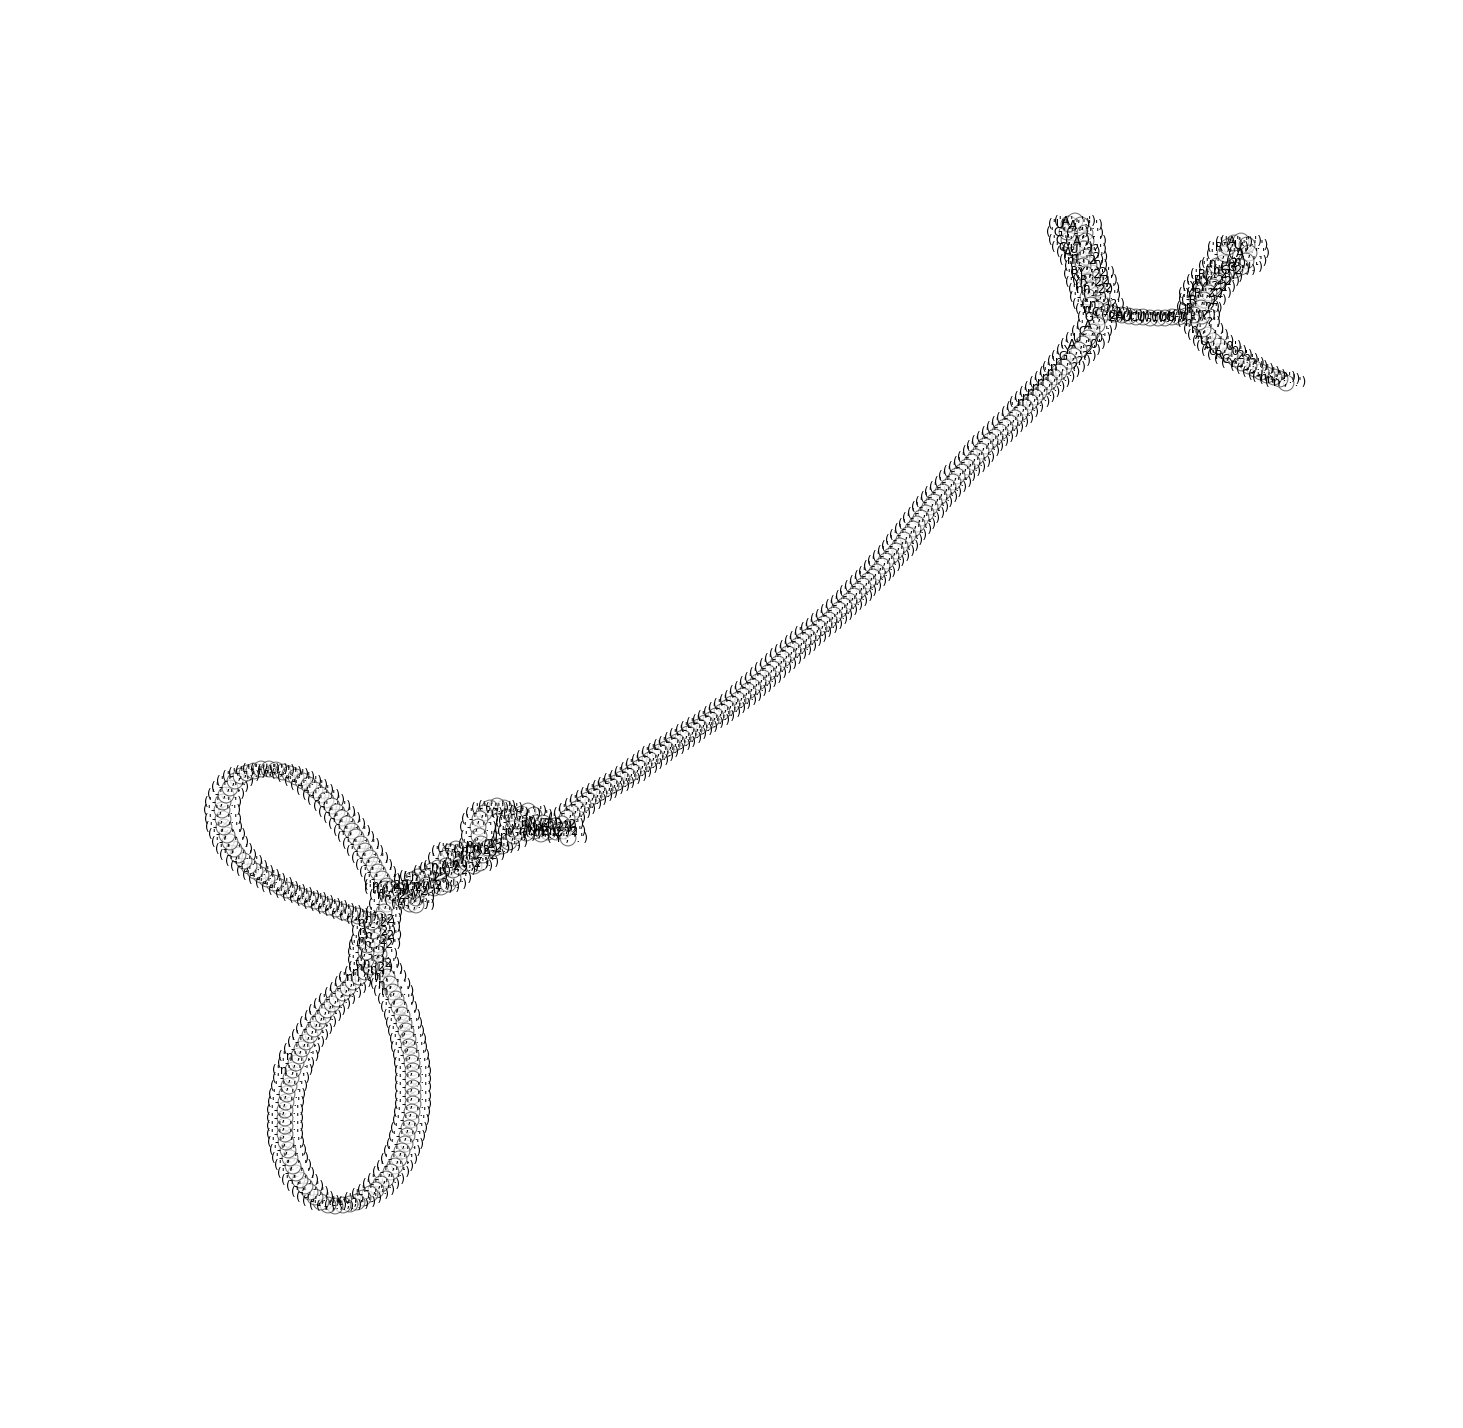

/home/alsheikm/GitDir/EeDN_work/StoExamples/StoExmapleSmall/negatives-sto
('seq', 'UUAGCACU-Cnnn-Rnn----nn--G--AG--UGCUAAnn------nnnnnnnn------n-nnnnnnn')
('stru', '<<<<<<<<.<<__.___._.._>..>..>>..>>>>>>::..:...::::::::::....:::::::::')
enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): sequence, covaration
('Graph title', '550-904-1-0')


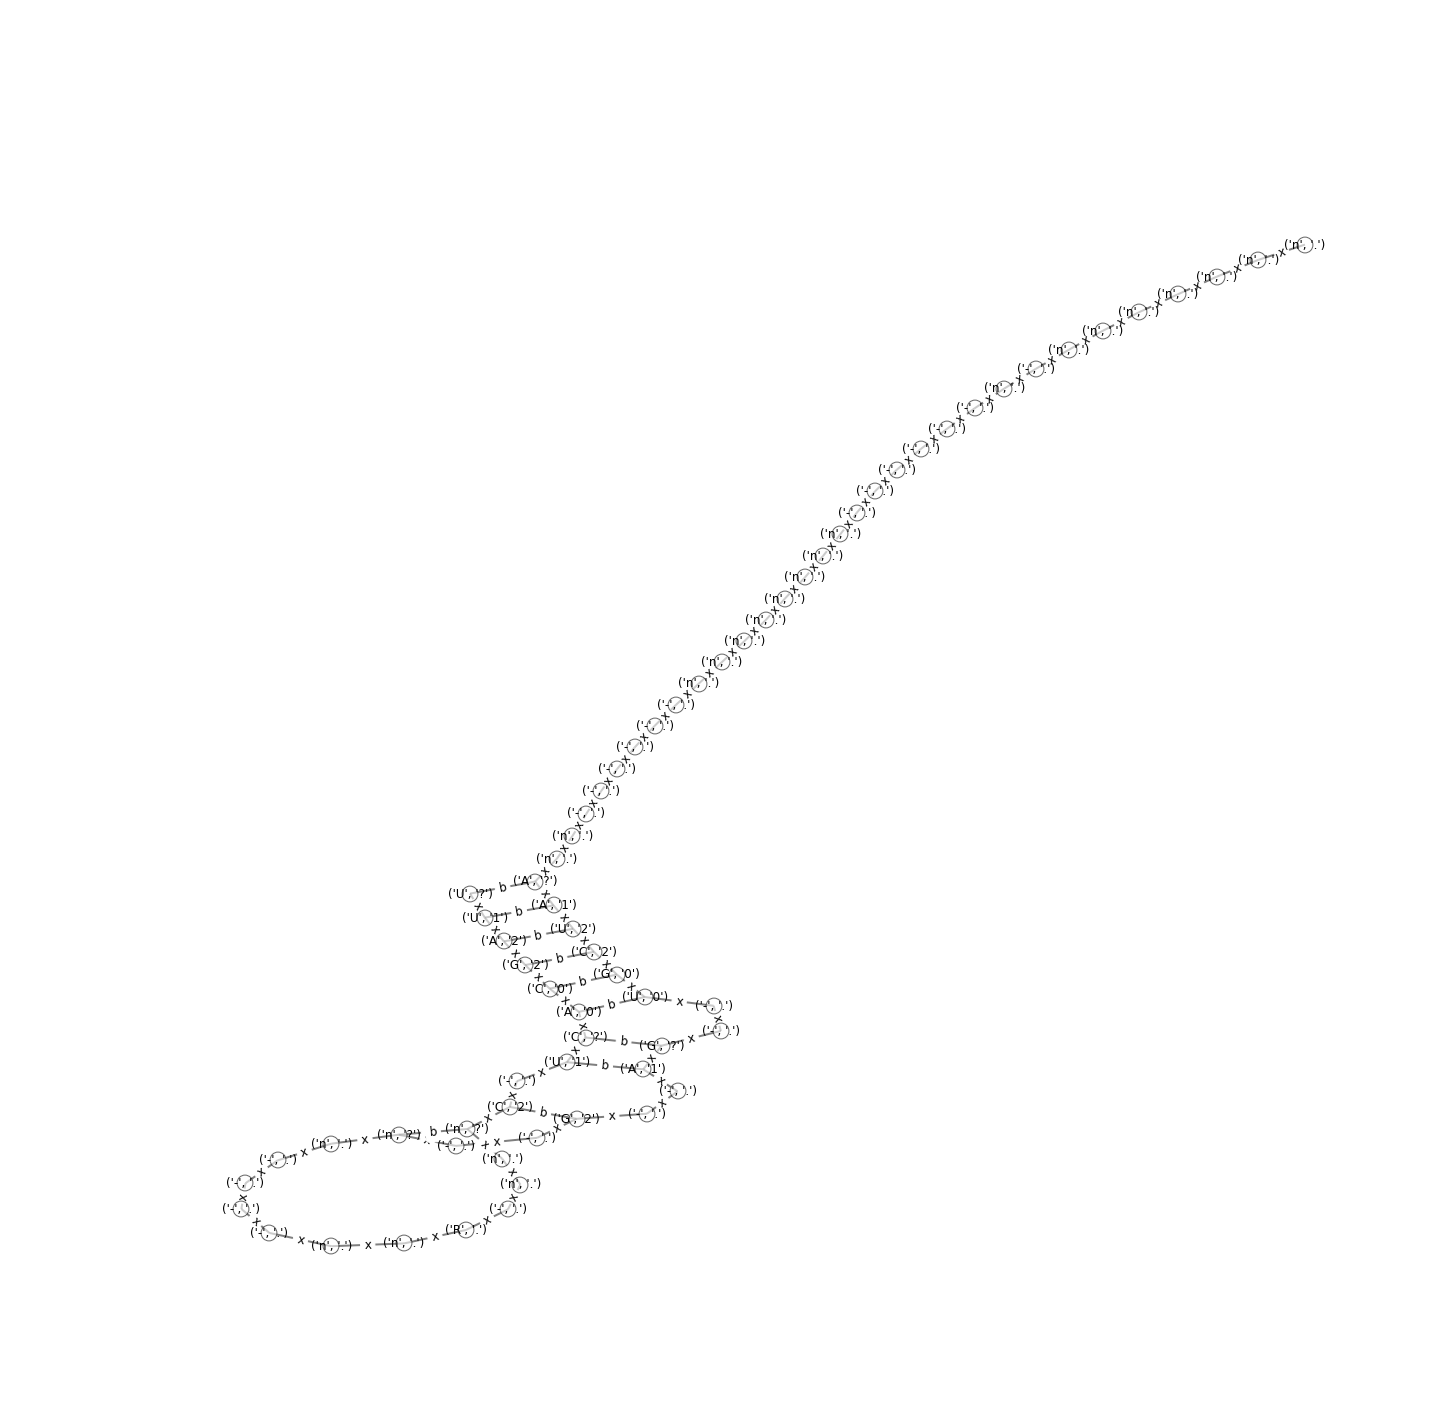

('seq', 'UAnnnUnnnnnnnnn----------------------U-UAG-C--ACUCnn-nnnn--nnn---GAG--UGCUAA--n--------------------nnnnnn')
('stru', '::::::::::::::::.....................<.<<<.<..<<<<__.____..__..._>>>..>>>>>>..:....................::::::')
enter graph key (sequence, structure, covaration, conservation_stringth, entropy_3): sequence, covaration
('Graph title', '550-1143-1-0')


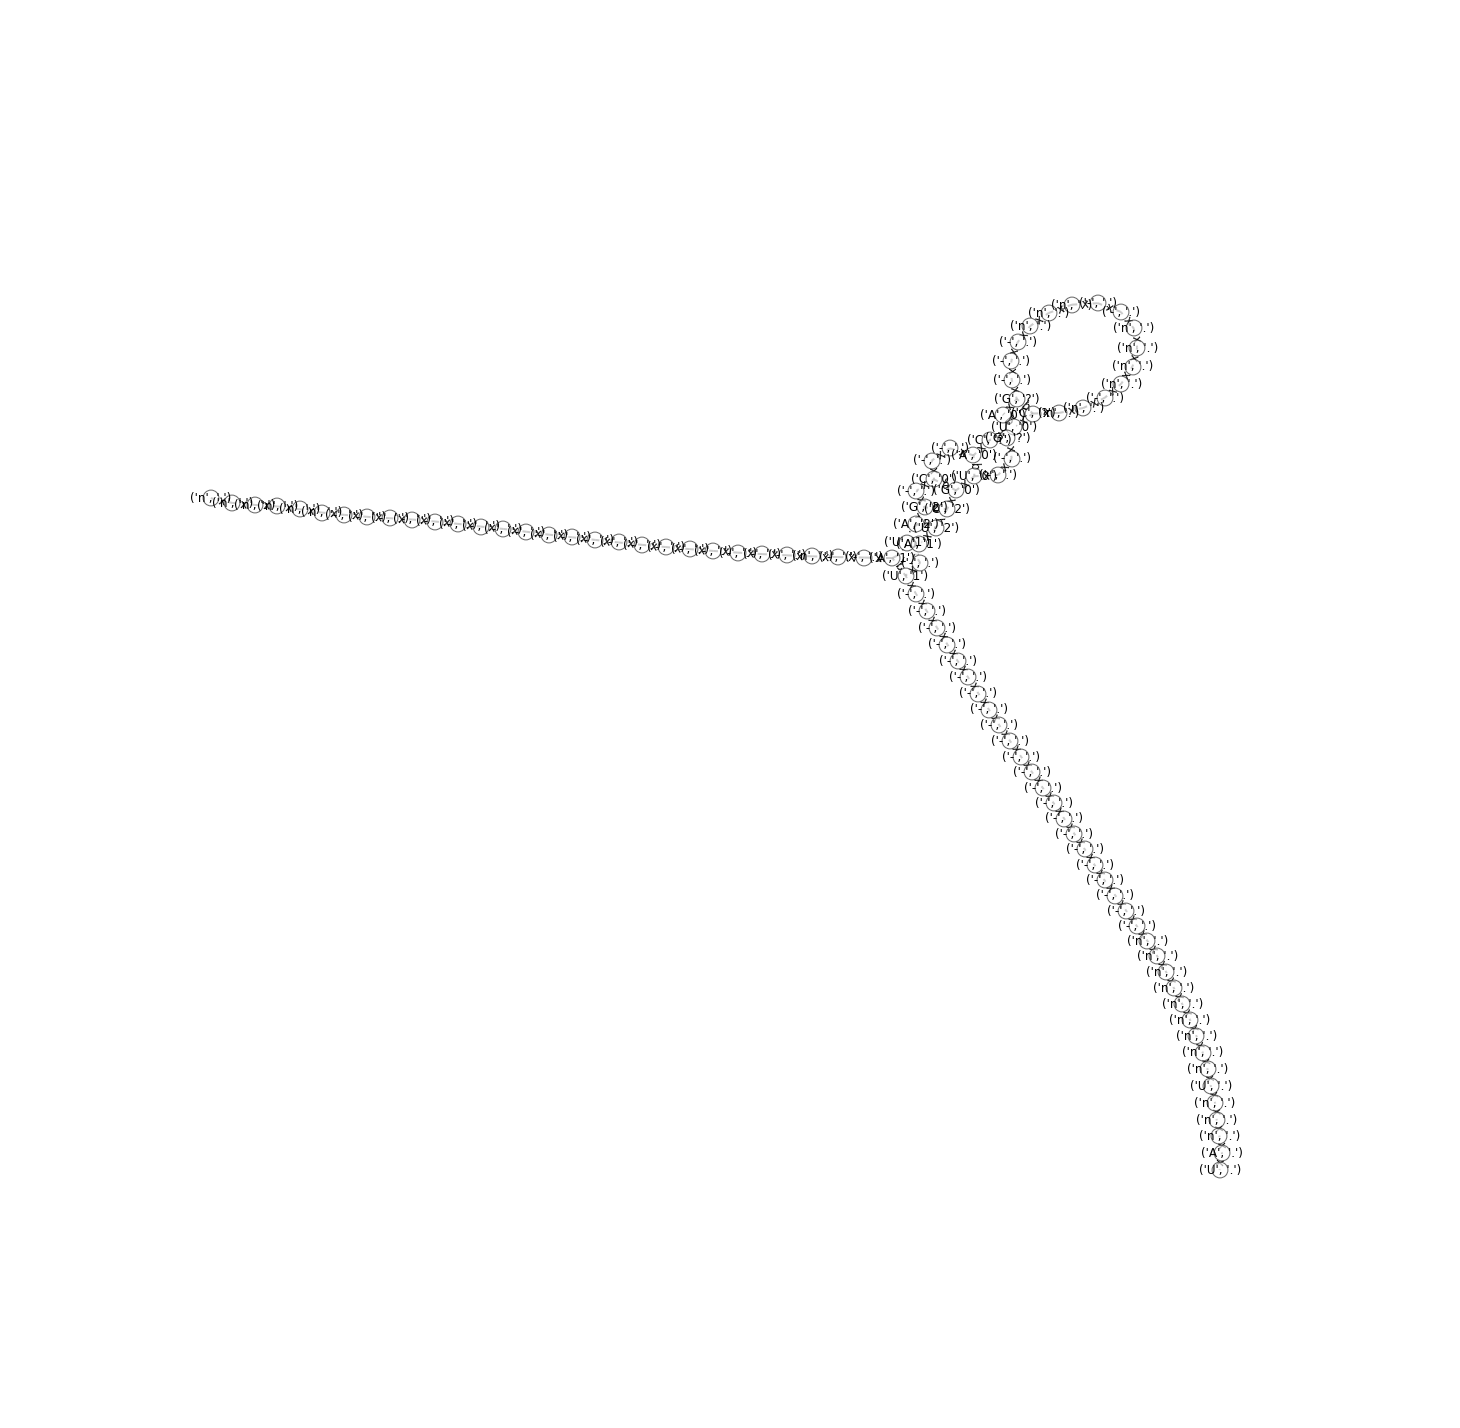

('seq', 'n-UG--GG-Gn--AUGUUUUUAUUGRCGnnnUUUCCCYG-G')
('stru', '<.<<..<<.<<..<<<<<______>>>>---->>>>>>>.>')


In [ ]:
files_dir = "/home/alsheikm/GitDir/EeDN_work/StoExamples/StoExmapleSmall"
partition_dir = "/home/alsheikm/GitDir/EeDN_work/StoExamples/partitionFiles"
Folder_to_Graph = _readFolderAndGraphsGenerating(files_dir)
write_merge_file = _writeMergeClassFile(partition_dir, files_dir)
